In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time
import warnings

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, cross_val_score, RepeatedKFold, StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

from xgboost import XGBClassifier

start_time = time.time()

# Data

In [2]:
train = pd.read_csv('input/train.csv')

def treat_features(df):

  df['Age'] = df['Age'].fillna(df['Age'].median())

  df['Sex'] = df['Sex'].map({'male': 1, 'female': 0})

  embarked = pd.get_dummies(df['Embarked'], prefix='Embarked').astype(int)
  df = pd.concat([df, embarked], axis=1)

  df['cabin_multiple'] = df.Cabin.apply(lambda x: 0 if pd.isna(x) else len(x.split(' ')))
  df['cabin_adv'] = df.Cabin.apply(lambda x: str(x)[0])
  cabins = pd.get_dummies(df['cabin_adv'], prefix='Cabin_Category').astype(int)
  df = pd.concat([df, cabins], axis=1)
  
  df['Name_Mister'] = df['Name'].str.contains("Mr|Mister").astype(int)
  df['Name_Miss'] = df['Name'].str.contains("Miss").astype(int)

  df = df.drop(['Name', 'Embarked', 'Cabin', 'cabin_adv', 'Ticket'], axis=1)

  return df

In [3]:
train = treat_features(train)
X = train.drop('Survived', axis=1).reset_index(drop=True)
y = train['Survived'].reset_index(drop=True)

# Models

In [4]:
resultados = {
    'RandomForest': [],
    'LogisticRegression': [],
    'RandomForest - GridSearch': [],
    'XGBoost': [],
    'XGBoost - GridSearch': []
}

kf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

fold = 0
for linhas_treino, linhas_valid in kf.split(X, y):
    fold += 1
    print("")
    print(f"Starting fold {fold}")  
    
    X_treino, X_valid = X.iloc[linhas_treino], X.iloc[linhas_valid]
    y_treino, y_valid = y.iloc[linhas_treino], y.iloc[linhas_valid] 
    
    scaler = StandardScaler()
    X_train_scaled =  pd.DataFrame(scaler.fit_transform(X_treino), columns=X_treino.columns)
    X_val_scaled = pd.DataFrame(scaler.transform(X_valid), columns=X_valid.columns) 
    
    # LogisticRegression
    print("Training Logistic Regression...")
    logreg = LogisticRegression()
    logreg.fit(X_train_scaled, y_treino)
    logreg_y_pred = logreg.predict(X_val_scaled)
    logreg_acc = accuracy_score(y_valid, logreg_y_pred)
    resultados['LogisticRegression'].append(logreg_acc)
    print(f"Logistic Regression accuracy for fold {fold}: {logreg_acc.round(5)}")    
    
    # Random Forest Classifier
    print("Training Random Forest Classifier...")
    rf = RandomForestClassifier(n_jobs=-1, random_state=0)
    rf.fit(X_treino, y_treino)
    rf_y_pred = rf.predict(X_valid)
    rf_acc = accuracy_score(y_valid, rf_y_pred)
    resultados['RandomForest'].append(rf_acc)
    print(f"Random Forest accuracy for fold {fold}: {rf_acc.round(5)}")  
    
    # Random Forest Classifier - GridSearch
    print("Performing GridSearch on Random Forest...")
    param_grid = {
        'n_estimators': [50, 100, 200],
        'max_depth': [5, 8, 15, 20, 30],
        'min_samples_split': [2, 4, 6, 8, 10],
        'min_samples_leaf': [1, 2, 4]
    }
    grid_search_rf = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1, verbose=0)
    grid_search_rf.fit(X_treino, y_treino)
    rf_best_model = grid_search_rf.best_estimator_
    rf_best_model_y_pred = rf_best_model.predict(X_valid)
    rf_best_model_acc = accuracy_score(y_valid, rf_best_model_y_pred)
    resultados['RandomForest - GridSearch'].append(rf_best_model_acc)
    print(f"Random Forest with GridSearch accuracy for fold {fold}: {rf_best_model_acc.round(5)}")   
    
    # XGBoost naive
    print("Training XGBoost...")
    bst = XGBClassifier(objective='binary:logistic')
    bst.fit(X_treino, y_treino)
    bst_y_pred = bst.predict(X_valid)
    bst_acc = accuracy_score(y_valid, bst_y_pred)
    resultados['XGBoost'].append(bst_acc)
    print(f"XGBoost accuracy for fold {fold}: {bst_acc.round(5)}")   
    
    # XGBoost GridSearch
    print("Performing GridSearch on XGBoost...")
    param_grid_bst = {
        'n_estimators': [50, 100, 200],
        'max_depth': range(3, 11, 1),
        'learning_rate': [0.001, 0.01, 0.1]
    }
    grid_search_bst = GridSearchCV(estimator=bst, param_grid=param_grid_bst, cv=5, n_jobs=-1, verbose=0)
    grid_search_bst.fit(X_treino, y_treino)
    best_model_bst = grid_search_bst.best_estimator_
    best_model_bst_y_pred = best_model_bst.predict(X_valid)
    best_model_bst_acc = accuracy_score(y_valid, best_model_bst_y_pred)
    resultados['XGBoost - GridSearch'].append(best_model_bst_acc)
    print(f"XGBoost with GridSearch accuracy for fold {fold}: {best_model_bst_acc.round(5)}")

print("Cross-validation complete.")
resultados = pd.DataFrame(resultados)


Starting fold 1
Training Logistic Regression...
Logistic Regression accuracy for fold 1: 0.82492
Training Random Forest Classifier...
Random Forest accuracy for fold 1: 0.81818
Performing GridSearch on Random Forest...
Random Forest with GridSearch accuracy for fold 1: 0.85859
Training XGBoost...
XGBoost accuracy for fold 1: 0.83165
Performing GridSearch on XGBoost...
XGBoost with GridSearch accuracy for fold 1: 0.84848

Starting fold 2
Training Logistic Regression...
Logistic Regression accuracy for fold 2: 0.80135
Training Random Forest Classifier...
Random Forest accuracy for fold 2: 0.80808
Performing GridSearch on Random Forest...
Random Forest with GridSearch accuracy for fold 2: 0.82155
Training XGBoost...
XGBoost accuracy for fold 2: 0.77778
Performing GridSearch on XGBoost...
XGBoost with GridSearch accuracy for fold 2: 0.81145

Starting fold 3
Training Logistic Regression...
Logistic Regression accuracy for fold 3: 0.82492
Training Random Forest Classifier...
Random Forest a

# Evaluation

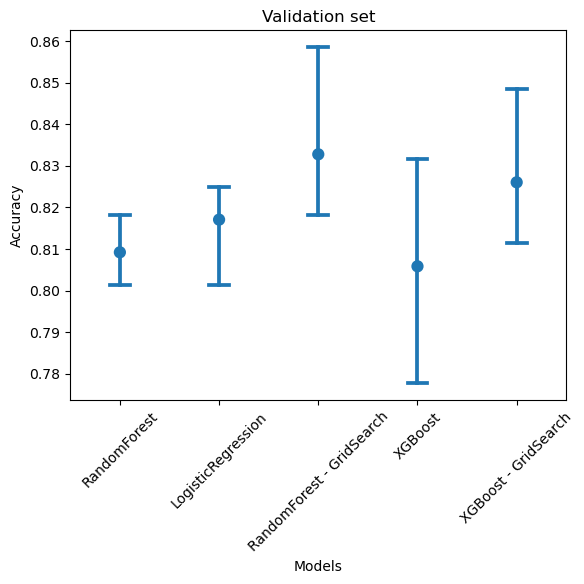

In [5]:
warnings.filterwarnings('ignore')

x = sns.pointplot(resultados, linestyles="none", capsize=.2)
_ = plt.ylabel("Accuracy")
_ = plt.xlabel("Models")
_ = plt.title("Validation set")
_ = x.set_xticklabels(x.get_xticklabels(), rotation=45)

# Predictions on test dataset with best model performed on traininig data

In [6]:
test = pd.read_csv('input/test.csv')
ids = test['PassengerId']
test = treat_features(test)
test['Fare'] = test['Fare'].fillna(test['Fare'].median())
test['Cabin_Category_T'] = 0
test = test[['PassengerId', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch',
       'Fare', 'Embarked_C', 'Embarked_Q', 'Embarked_S',
       'cabin_multiple', 'Cabin_Category_A', 'Cabin_Category_B',
       'Cabin_Category_C', 'Cabin_Category_D', 'Cabin_Category_E',
       'Cabin_Category_F', 'Cabin_Category_G', 'Cabin_Category_T',
       'Cabin_Category_n', 'Name_Mister', 'Name_Miss']]

pred = best_model_bst.predict(test)

result = pd.DataFrame({'PassengerId': ids, 'Survived': pred.round().astype(int)})

result.to_csv('titanic_kaggle_submit.csv', index=False)

Submission accuracy = 0.7703

In [7]:
round((time.time() - start_time) / 60, 3)

5.005